In [1]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana as pdn
import pickle as pkl
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories
for d in ["data", "logs", "models", "networks"]:
    if not os.path.isdir(d):
        os.mkdir(d)

## Trips

In [36]:
# Bring the trips
trips = pd.read_csv(f"data/trips2.csv")

trips = trips[trips['Mun_Ori'] != trips['Mun_Des']]

In [37]:
# Filtrar

# trips = trips[trips['Proposito'] == 'Trabajo']
trips = trips[(trips['Act_Ori'].isin(['Trabajo habitual', 'Asuntos trabajo'])) | (trips['Act_Des'].isin(['Trabajo habitual', 'Asuntos trabajo']))]
trips

,Unnamed: 0,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,...,Per_hog,Turismos,Motos,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,Año
3,3,20,20,Donostialdea,Goierri,Donostia/San Sebastian,Beasain,Asuntos trabajo,Asuntos trabajo,Trabajo,...,2,3,1,1,5,1,1,2,1,2021
4,4,20,20,Debagoiena,Donostialdea,Arrasate/Mondragon,Donostia/San Sebastian,Asuntos trabajo,Asuntos trabajo,Trabajo,...,2,3,1,1,5,1,1,2,2,2021
9,9,20,20,Donostialdea,Urola Kosta,Andoain,Zarautz,Trabajo habitual,Gestiones personales,Trabajo,...,2,3,1,1,5,1,1,2,2,2021
17,17,20,20,Goierri,Donostialdea,Beasain,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,...,1,1,1,1,5,1,1,2,2,2021
18,18,20,20,Donostialdea,Goierri,Andoain,Beasain,Residencia Habitual,Trabajo habitual,Trabajo,...,1,1,1,1,5,1,1,2,2,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22074,22074,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Residencia Habitual,Trabajo,...,2,3,2,1,5,1,1,1,2,2011
22076,22076,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Centro estudios,Trabajo habitual,Trabajo,...,2,3,2,2,5,1,1,2,2,2011
22077,22077,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Centro estudios,Estudio,...,2,3,2,2,5,1,1,2,2,2011
22079,22079,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Residencia Habitual,Trabajo habitual,Trabajo,...,2,3,2,2,5,1,1,2,2,2011


In [86]:
trips = trips.drop(columns=["elev"])

In [38]:
# Expandir los trips, hacer que cada trayecto sea una fila

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips.iterrows():
    valores_columnas = row[trips.columns]
    repeticiones = row['elev']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips = pd.DataFrame(nuevas_filas, columns=trips.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips = trips.drop(columns=["elev"])

# Mezclo las filas de manera aleatoria
trips = trips.sample(frac=1).reset_index(drop=True)

In [39]:
# Filtrar

trips = trips.drop(columns=['Unnamed: 0', 'Año'])

# Elimino las filas que tienen NaN o NS/NC como pueblos origen o destino (no cambia mucho porque eran pocas filas)

pueblos = ['Donostia/San Sebastian', 'Arrasate/Mondragon', 'Urnieta',
       'Andoain', 'Zarautz', 'Beasain', 'Hernani', 'Irun', 'Usurbil',
       'Villabona', 'Lasarte-Oria', 'Hondarribia', 'Tolosa',
       'Aretxabaleta', 'Bergara', 'Azkoitia', 'Ordizia', 'Azpeitia',
       'Elgoibar', 'Zumaia', 'Orio', 'Zumarraga', 'Lazkao', 'Legazpi',
       'Oñati', 'Deba', 'Eibar', 'Urretxu', 'Errenteria', 'Lezo',
       'Oiartzun', 'Pasaia', 'Mutriku']

trips = trips[trips['Mun_Ori'].isin(pueblos)]
trips = trips[trips['Mun_Des'].isin(pueblos)]

trips = trips.reset_index(drop=True)

In [40]:
trips

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Comarca,Per_hog,Turismos,Motos,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr
0,20,20,Donostialdea,Bidasoa,Oiartzun,Irun,Compras personales,Trabajo habitual,Trabajo,Coche conductor,...,Bidasoa,1,2,2,1,5,1,1,2,2
1,20,20,Donostialdea,Bidasoa,Donostia/San Sebastian,Irun,Residencia Habitual,Trabajo habitual,Trabajo,Coche conductor,...,Donostialdea,1,3,1,1,6,1,1,1,2
2,20,20,Donostialdea,Donostialdea,Andoain,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,Coche conductor,...,Donostialdea,2,2,1,2,4,1,1,2,2
3,20,20,Debabarrena,Debagoiena,Eibar,Bergara,Trabajo habitual,Residencia Habitual,Trabajo,Coche conductor,...,Debagoiena,2,3,1,1,5,1,1,2,2
4,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Residencia Habitual,Trabajo habitual,Trabajo,Coche conductor,...,Bidasoa,2,3,1,1,5,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563599,20,20,Donostialdea,Bidasoa,Hernani,Irun,Residencia Habitual,Trabajo habitual,Trabajo,RENFE,...,Donostialdea,1,1,1,2,6,1,1,2,2
563600,20,20,Goierri,Goierri,Beasain,Zumarraga,Residencia Habitual,Trabajo habitual,Trabajo,Coche conductor,...,Goierri,1,3,1,1,3,1,1,2,2
563601,20,20,Donostialdea,Tolosaldea,Donostia/San Sebastian,Tolosa,Residencia Habitual,Trabajo habitual,Trabajo,RENFE,...,Donostialdea,1,2,1,2,6,1,1,2,2
563602,20,20,Donostialdea,Donostialdea,Lasarte-Oria,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,Autobús interurbano,...,Donostialdea,1,1,1,2,4,1,2,2,2


# Asignar Lat y Long origen y destino

Bring the buildings

In [6]:
# Leer el archivo Shapefile
gdf = gpd.read_file(f"data/ERAIKINAK_EDIFICIOS/buildings.shp")

# Pasar las geometrias de los edificios de sistema UTM a sistema decimal de coordenadas
crs_objetivo = 'EPSG:4326'  # WGS84
gdf = gdf.to_crs(crs_objetivo)

# Crear una columna que contiene el centroide del edificio, para obtener un punto
gdf['Centroide'] = gdf['geometry'].centroid
gdf.columns

C:\Users\iazka\AppData\Local\Temp\ipykernel_20300\1237833868.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['Centroide'] = gdf['geometry'].centroid


Index(['Town', 'Edificabil', 'Solar', 'Vivienda', 'Trastero', 'Garaje Cer',
       'Agropecuar', 'Local Come', 'Industrial', 'Almacen', 'Deportivo',
       'Cultural', 'Educativo', 'Oficina', 'Hosteleria', 'Obras Urba',
       'Altura men', 'Terraza', 'Accesos y', 'Jardin', 'Sanidad', 'Deposito',
       'Duplex', 'Plaza Park', 'Religioso', 'Espectacul', 'geometry',
       'Centroide'],
      dtype='object')

In [89]:
asignaciones = {
    'Otra vivienda': ['Vivienda', 'Duplex'],
    'Centro estudios': ['Educativo'],
    'Compras doméstico-familiares': ['Local Come'],
    'Asuntos trabajo': ['Oficina'],
    'Trabajo habitual': ['Oficina'],
    'Ocio, cultura, deporte': ['Deportivo', 'Cultural', 'Hosteleria', 'Terraza', 'Jardin', 'Religioso', 'Espectacul'],
    'Acompañamiento de ayuda, cuidado': ['Local Come'],
    'Residencia Habitual': ['Vivienda', 'Duplex'],
    'Médico / Hospital': ['Sanidad'],
    'Gestiones personales': ['Local Come'],
    'Compras personales': ['Local Come'],
    'Otras actividades': ['Local Come'],
    'Gestiones doméstico-familiares': ['Local Come'],

}

# Encontrar la longitud máxima de todas las listas
max_length = max(len(lista) for lista in asignaciones.values())

# Rellenar las listas con valores NaN para que tengan la misma longitud
for columna in asignaciones:
    asignaciones[columna] += [np.nan] * (max_length - len(asignaciones[columna]))

# Crear el DataFrame a partir del diccionario
asignaciones = pd.DataFrame(asignaciones)

In [90]:
# Función para obtener la lista de una columna específica
def obtener_lista_por_columna(df, columna):
    if columna in df.columns:
        l = df[columna].tolist()
        l = [x for x in l if isinstance(x, str)]
        return l
    else:
        return []

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_origen(row):
    matching_rows = gdf[gdf['Town'] == row['Mun_Ori']] # Lista con todos las RC de ese pueblo
    matching_usos = obtener_lista_por_columna(asignaciones, row['Act_Ori']) # Lista con los posibles usos de esa actividad
    matching_rows = matching_rows[(matching_rows[matching_usos] != 0).any(axis=1)] # De las RC del pueblo, coge solo las que no tienen nulo el m2, mínimo alguno de los usos de suelo asignado a esa actividad origen. Esto es, si hay alguna RC que no tiene ningún uso de suelo de interés para esa actividad, se elimina.

    # Genero una matriz auxiliar quitando Town, geometry y Centroide para hacer los calculos
    auxiliar = matching_rows.drop(columns=['Town', 'geometry', 'Centroide'])
    # Hasta este punto, tengo un gdf con las RC de pueblo adecuado y con todas las RC que hacen match con esa actividad, esto es, no hay ninguna fila que tenga todos los m2 nulos.
    # El próximo paso es asignar una fila (RC), y para ello escojo por probabilidad una ubicación exacta de la matriz (tanto RC como uso de suelo) y selecciono esa fila (RC) para pasarle

    if not matching_rows.empty:
        probabilidades = auxiliar.values / auxiliar.values.sum() # Normalizar los valores para representar probabilidades
        # Generar números aleatorios para seleccionar fila y columna
        fila_seleccionada = random.choices(range(auxiliar.shape[0]), weights=probabilidades.sum(axis=1))[0]
        columna_seleccionada = random.choices(range(auxiliar.shape[1]), weights=probabilidades[fila_seleccionada])[0]
        valor_seleccionado = auxiliar.iloc[fila_seleccionada, columna_seleccionada]         # Obtener el valor seleccionado, fila y columna
        fila = matching_rows.index[fila_seleccionada] # Devolver la fila, la columna y el valor seleccionado
        return gdf.loc[fila, 'Centroide']
    else:
        return None

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_destino(row):
    matching_rows = gdf[gdf['Town'] == row['Mun_Des']] # Lista con todos las RC de ese pueblo
    matching_usos = obtener_lista_por_columna(asignaciones, row['Act_Des']) # Lista con los posibles usos de esa actividad
    matching_rows = matching_rows[(matching_rows[matching_usos] != 0).any(axis=1)] # De las RC del pueblo, coge solo las que no tienen nulo el m2, mínimo alguno de los usos de suelo asignado a esa actividad origen. Esto es, si hay alguna RC que no tiene ningún uso de suelo de interés para esa actividad, se elimina.

    # Genero una matriz auxiliar quitando Town, geometry y Centroide para hacer los calculos
    auxiliar = matching_rows.drop(columns=['Town', 'geometry', 'Centroide'])
    # Hasta este punto, tengo un gdf con las RC de pueblo adecuado y con todas las RC que hacen match con esa actividad, esto es, no hay ninguna fila que tenga todos los m2 nulos.
    # El próximo paso es asignar una fila (RC), y para ello escojo por probabilidad una ubicación exacta de la matriz (tanto RC como uso de suelo) y selecciono esa fila (RC) para pasarle

    if not matching_rows.empty:
        probabilidades = auxiliar.values / auxiliar.values.sum() # Normalizar los valores para representar probabilidades
        # Generar números aleatorios para seleccionar fila y columna
        fila_seleccionada = random.choices(range(auxiliar.shape[0]), weights=probabilidades.sum(axis=1))[0]
        columna_seleccionada = random.choices(range(auxiliar.shape[1]), weights=probabilidades[fila_seleccionada])[0]
        valor_seleccionado = auxiliar.iloc[fila_seleccionada, columna_seleccionada]         # Obtener el valor seleccionado, fila y columna
        fila = matching_rows.index[fila_seleccionada] # Devolver la fila, la columna y el valor seleccionado
        return gdf.loc[fila, 'Centroide']
    else:
        return None


# Aplicar la función a trips para crear la columna Edif_ORIGEN y Edif_DESTINO
trips['Edif_Ori'] = trips.apply(asignar_coord_origen, axis=1)
trips['Edif_Des'] = trips.apply(asignar_coord_destino, axis=1)
trips

C:\Users\iazka\AppData\Local\Temp\ipykernel_20300\2815328858.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips['Edif_Ori'] = trips.apply(asignar_coord_origen, axis=1)
C:\Users\iazka\AppData\Local\Temp\ipykernel_20300\2815328858.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips['Edif_Des'] = trips.apply(asignar_coord_destino, axis=1)


,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Turismos,Motos,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,Edif_Ori,Edif_Des
0,20,20,Donostialdea,Goierri,Donostia/San Sebastian,Beasain,Asuntos trabajo,Asuntos trabajo,Trabajo,Coche conductor,...,3,1,1,5,1,1,2,1,POINT (-1.9681194513742595 43.309596943255336),POINT (-2.2095584305901395 43.04371482063348)
1,20,20,Debagoiena,Donostialdea,Arrasate/Mondragon,Donostia/San Sebastian,Asuntos trabajo,Asuntos trabajo,Trabajo,Coche conductor,...,3,1,1,5,1,1,2,2,POINT (-2.5070078588085796 43.060520815469545),POINT (-1.9842739555688103 43.317133416466774)
2,20,20,Donostialdea,Urola Kosta,Andoain,Zarautz,Trabajo habitual,Gestiones personales,Trabajo,Coche conductor,...,3,1,1,5,1,1,2,2,POINT (-2.0298698953552083 43.202269636911204),POINT (-2.175352455803188 43.28414304240681)
5,20,20,Goierri,Donostialdea,Beasain,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,RENFE,...,1,1,1,5,1,1,2,2,POINT (-2.194872615820847 43.04722658184545),POINT (-2.0230890952409384 43.21146153769588)
6,20,20,Donostialdea,Goierri,Andoain,Beasain,Residencia Habitual,Trabajo habitual,Trabajo,RENFE,...,1,1,1,5,1,1,2,2,POINT (-2.017355218268839 43.22180741844775),POINT (-2.199206678962475 43.04432343132505)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Residencia Habitual,Trabajo,Coche conductor,...,3,2,1,5,1,1,1,2,POINT (-1.767784500948133 43.33686071905806),POINT (-1.827934875733873 43.34100468883209)
5081,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Centro estudios,Trabajo habitual,Trabajo,Coche conductor,...,3,2,2,5,1,1,2,2,POINT (-1.8183407031694288 43.341178772922134),POINT (-1.8054036997226623 43.333622307912535)
5082,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Centro estudios,Estudio,Coche conductor,...,3,2,2,5,1,1,2,2,POINT (-1.826806847083897 43.327675109320396),POINT (-1.8021300545608978 43.37242130377832)
5083,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Residencia Habitual,Trabajo habitual,Trabajo,Coche conductor,...,3,2,2,5,1,1,2,2,POINT (-1.7930668973937913 43.36946906838493),POINT (-1.8499097690229764 43.327468244806326)


In [91]:
# Pasa de un punto en formato WKT a dos columnas con LONG y LAT

from shapely import wkt
from shapely.geometry import Point

def extraer_longitud(punto):
    return punto.x

def extraer_latitud(punto):
    return punto.y

# from shapely import wkt
# from shapely.geometry import Point

# def extraer_longitud(punto_wkt):
#     punto = wkt.loads(punto_wkt)
#     return punto.x

# def extraer_latitud(punto_wkt):
#     punto = wkt.loads(punto_wkt)
#     return punto.y

trips['O_long'] = trips['Edif_Ori'].apply(extraer_longitud)
trips['O_lat'] = trips['Edif_Ori'].apply(extraer_latitud)
trips['D_long'] = trips['Edif_Des'].apply(extraer_longitud)
trips['D_lat'] = trips['Edif_Des'].apply(extraer_latitud)

# Eliminar columnas innecesarias

trips = trips.drop(columns=["Edif_Ori","Edif_Des"])
trips

C:\Users\iazka\AppData\Local\Temp\ipykernel_20300\1509457991.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips['O_long'] = trips['Edif_Ori'].apply(extraer_longitud)
C:\Users\iazka\AppData\Local\Temp\ipykernel_20300\1509457991.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips['O_lat'] = trips['Edif_Ori'].apply(extraer_latitud)
C:\Users\iazka\AppData\Local\Temp\ipykernel_20300\1509457991.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,O_long,O_lat,D_long,D_lat
0,20,20,Donostialdea,Goierri,Donostia/San Sebastian,Beasain,Asuntos trabajo,Asuntos trabajo,Trabajo,Coche conductor,...,1,5,1,1,2,1,-1.968119,43.309597,-2.209558,43.043715
1,20,20,Debagoiena,Donostialdea,Arrasate/Mondragon,Donostia/San Sebastian,Asuntos trabajo,Asuntos trabajo,Trabajo,Coche conductor,...,1,5,1,1,2,2,-2.507008,43.060521,-1.984274,43.317133
2,20,20,Donostialdea,Urola Kosta,Andoain,Zarautz,Trabajo habitual,Gestiones personales,Trabajo,Coche conductor,...,1,5,1,1,2,2,-2.029870,43.202270,-2.175352,43.284143
5,20,20,Goierri,Donostialdea,Beasain,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,RENFE,...,1,5,1,1,2,2,-2.194873,43.047227,-2.023089,43.211462
6,20,20,Donostialdea,Goierri,Andoain,Beasain,Residencia Habitual,Trabajo habitual,Trabajo,RENFE,...,1,5,1,1,2,2,-2.017355,43.221807,-2.199207,43.044323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Residencia Habitual,Trabajo,Coche conductor,...,1,5,1,1,1,2,-1.767785,43.336861,-1.827935,43.341005
5081,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Centro estudios,Trabajo habitual,Trabajo,Coche conductor,...,2,5,1,1,2,2,-1.818341,43.341179,-1.805404,43.333622
5082,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Centro estudios,Estudio,Coche conductor,...,2,5,1,1,2,2,-1.826807,43.327675,-1.802130,43.372421
5083,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Residencia Habitual,Trabajo habitual,Trabajo,Coche conductor,...,2,5,1,1,2,2,-1.793067,43.369469,-1.849910,43.327468


In [92]:
trips.to_csv(f"data/Gipuzkoa_MT2.csv")

In [9]:
trips = pd.read_csv(f"data/Gipuzkoa_MT2.csv",index_col=0)

# Change modes of transportation

In [10]:
# Changes primary modes to a different model: auto or green_modes

trips = trips[trips['Modo'] != 'Otros']

# 5 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "Autobus"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "Autobus"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "Autobus"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "Tren"
# trips.loc[trips.Modo=="RENFE","Modo"] = "Tren"

# 2 MODOS, coche y green

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "Green"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "Green"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "Green"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "Green"
# trips.loc[trips.Modo=="RENFE","Modo"] = "Green"
# trips.loc[trips.Modo=="Andando","Modo"] = "Green"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Green"

# 2 MODOS, TP y coche

trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús urbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "TP"
trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "TP"
trips.loc[trips.Modo=="RENFE","Modo"] = "TP"
trips = trips[trips['Modo'] != 'Andando']
trips = trips[trips['Modo'] != 'Bicicleta']

# 3 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "PT"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "PT"
# trips.loc[trips.Modo=="RENFE","Modo"] = "PT"
# trips.loc[trips.Modo=="Andando","Modo"] = "Active modes"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Active modes"

# 4 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "PT"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "PT"
# trips.loc[trips.Modo=="RENFE","Modo"] = "PT"
# trips.loc[trips.Modo=="Andando","Modo"] = "Andando"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Bicicleta"

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.Modo==label].shape[0]:,}" for label in trips.Modo.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Coche: 2,071
TP: 411
Total: 2,482


In [11]:
# Reducir el numero de trips en coche a la suma del resto de modos.

# Numero de green trips
condicion = trips['Modo'] != 'Coche'
green_trips = condicion.sum()

condicion = trips['Modo'] == 'Coche'
coche_trips = condicion.sum()
eliminar=coche_trips-green_trips

#eliminar=len(trips['MODO_INFORME']=='Coche')-green_trips

# Escoger aleatoriamente ese numero de trips de todos los del coche

# Filtrar las filas que cumplen con el modo de transporte "coche"
coche_rows = trips[trips['Modo'] == 'Coche']

# Seleccionar aleatoriamente X filas del conjunto de filas "coche_rows"
muestras_aleatorias = coche_rows.sample(n=eliminar)

# Eliminar las filas que no fueron seleccionadas aleatoriamente
trips = trips[~trips.index.isin(muestras_aleatorias.index)]

trips=trips.reset_index(drop=True)

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.Modo==label].shape[0]:,}" for label in trips.Modo.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Coche: 411
TP: 411
Total: 822


# Add time travel

In [5]:
# Crea un diccionario, donde los valores son None y las claves son esas cuatro

networks = dict.fromkeys({
 "walk",
 "transit",
 "train",
 "drive",
})

# Asigna al valor correspondiente en el diccionario networks un objeto de red creado mediante el método from_hdf5() de la clase Network del módulo pdn.network. 
# Los creados con los codigos anteriores

for k in networks:
    print(k)
    networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')

walk
drive
train
transit


In [12]:
# Asignar tt a cada modo de transporte para cada trip

# Para cada trip, asigna la distancia mas corta que se puede hacer con Network (walk, drive, transit) con shortest_path_lengths
# Coge lat,long de origen y destino de cada trip. A ese origen y destino le asigna el nodo del Network correspondiente más cercano con get_node_ids
# Le pasa esos nodos del Network correspondiente a shortest_path_lengths, y este calcula la distancia entre esos nodos

for k in networks:
    if k != 'drive':
        trips[f"{k}_tt"] = networks[k].shortest_path_lengths(
            networks[k].get_node_ids(trips.O_long,trips.O_lat),
            networks[k].get_node_ids(trips.D_long,trips.D_lat)
            )

trips["walk_tt"] = trips["walk_tt"] / 80.46 # Pasar de distancia (m) a minutos con un ritmo de 3 mp/h = 80.46 m/min.

trips["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
            networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
            imp_name='drive_time_s'
            )

trips["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
            networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
            imp_name='distance'
            )

trips["drive_tt"] = trips["drive_tt"] / 60 # Para pasar a minutos
trips["bike_tt"] =  networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
            networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
            imp_name='distance'
            )
trips["bike_tt"] = trips["bike_tt"] * 60 / (1000*13.07)  # 13.07 km/h = 13.07*1000/60 m/min

# Eliminar andando y bike

trips = trips.drop(columns=['walk_tt', 'bike_tt'])
trips

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(4747441404, 2306456017), (8235607129, 7908608259), (5320435024, 4363663997), (259590790, 619322279), (2943224206, 8235607129), (581995285, 299168656), (531633035, 10308994426), (5320194882, 6600762366), (8235607129, 311048144), (8633045250, 2432248040)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(80032, 79105), (49952, 80032), (11763, 91291), (80032, 6510), (81084, 45381)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path 

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,crnt_mot,crnt_otr,O_long,O_lat,D_long,D_lat,train_tt,transit_tt,drive_tt,distance
0,20,20,Donostialdea,Goierri,Donostia/San Sebastian,Beasain,Asuntos trabajo,Asuntos trabajo,Trabajo,Coche,...,2,1,-1.968119,43.309597,-2.209558,43.043715,66.877,77.860,28.887217,42239.632
1,20,20,Goierri,Donostialdea,Beasain,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,2,2,-2.194873,43.047227,-2.023089,43.211462,44.022,60.300,18.177500,25353.540
2,20,20,Donostialdea,Goierri,Andoain,Beasain,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,2,2,-2.017355,43.221807,-2.199207,43.044323,43.016,71.818,17.583900,26784.543
3,20,20,Donostialdea,Donostialdea,Andoain,Hernani,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,2,2,-2.024679,43.212779,-1.947789,43.260284,59.034,44.930,10.930483,9472.008
4,20,20,Bidasoa,Donostialdea,Irun,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,2,1,-1.849910,43.327468,-2.024041,43.223825,89.545,59.151,16.267917,21572.818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,20,20,Urola Kosta,Debabarrena,Zarautz,Eibar,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,2,-2.174992,43.285898,-2.452215,43.192669,68.632,23.445,18.028033,33167.939
818,20,20,Tolosaldea,Donostialdea,Tolosa,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,2,2,-2.070803,43.131081,-1.984736,43.316111,51.495,47.134,17.844650,24070.304
819,20,20,Bidasoa,Bidasoa,Irun,Hondarribia,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,2,-1.767785,43.336861,-1.827935,43.341005,69.137,42.036,8.293267,7040.325
820,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Centro estudios,Trabajo habitual,Trabajo,Coche,...,2,2,-1.818341,43.341179,-1.805404,43.333622,22.025,27.517,3.594117,1820.621


# Añadir etiqueta dependiendo la hora del día

In [106]:
# Función para clasificar las horas en las categorías deseadas
def clasificar_horas(hora):
    if '05:00' <= hora < '10:00':
        return 'mañana'
    elif '10:00' <= hora < '17:00':
        return 'día'
    elif '17:00' <= hora < '21:00':
        return 'tarde'
    else:
        return 'noche'

# Aplicar la función a la columna 'Horas' y crear una nueva columna 'Categoría'
trips['Hora_Ini'] = trips['Hora_Ini'].apply(clasificar_horas)
trips

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,O_long,O_lat,D_long,D_lat
0,20,20,Donostialdea,Urola Kosta,Andoain,Zarautz,Trabajo habitual,Gestiones personales,Trabajo,Coche,...,1,5,1,1,2,2,-2.029870,43.202270,-2.175352,43.284143
1,20,20,Goierri,Donostialdea,Beasain,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,1,5,1,1,2,2,-2.194873,43.047227,-2.023089,43.211462
2,20,20,Donostialdea,Goierri,Andoain,Beasain,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,1,5,1,1,2,2,-2.017355,43.221807,-2.199207,43.044323
3,20,20,Bidasoa,Donostialdea,Irun,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,5,1,1,2,1,-1.849910,43.327468,-2.024041,43.223825
4,20,20,Donostialdea,Donostialdea,Urnieta,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,2,4,1,1,1,2,-1.992841,43.236861,-2.019774,43.213609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,20,20,Donostialdea,Donostialdea,Oiartzun,Errenteria,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,2,5,1,1,2,2,-1.879693,43.307861,-1.898858,43.295561
818,20,20,Donostialdea,Donostialdea,Errenteria,Oiartzun,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,2,5,1,1,2,2,-1.904071,43.319947,-1.879693,43.307861
819,20,20,Donostialdea,Donostialdea,Errenteria,Oiartzun,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,5,1,1,2,2,-1.898624,43.294526,-1.871848,43.298110
820,20,20,Urola Kosta,Debabarrena,Zarautz,Eibar,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,5,1,1,1,2,-2.174992,43.285898,-2.452215,43.192669


In [ ]:
trips.to_csv(f"data/Gipuzkoa_for_MNL.csv")

In [ ]:
trips = pd.read_csv(f"data/Gipuzkoa_for_MNL.csv",index_col=0)


## Columns Encoding

In [71]:
trips

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,O_long,O_lat,D_long,D_lat
0,20,20,Donostialdea,Urola Kosta,Andoain,Zarautz,Trabajo habitual,Gestiones personales,Trabajo,Coche,...,1,5,1,1,2,2,-2.034667,43.206766,-2.175787,43.284831
1,20,20,Goierri,Donostialdea,Beasain,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,1,5,1,1,2,2,-2.217735,43.049998,-2.025911,43.212539
2,20,20,Donostialdea,Goierri,Andoain,Beasain,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,1,5,1,1,2,2,-2.017841,43.208409,-2.217441,43.046812
3,20,20,Donostialdea,Donostialdea,Andoain,Hernani,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,5,1,1,2,2,-2.013573,43.214059,-1.986740,43.275951
4,20,20,Urola Kosta,Donostialdea,Zarautz,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,5,1,1,2,2,-2.162206,43.287072,-2.023843,43.213488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,20,20,Donostialdea,Donostialdea,Oiartzun,Errenteria,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,2,5,1,1,2,2,-1.844504,43.307569,-1.898905,43.296643
818,20,20,Donostialdea,Donostialdea,Errenteria,Oiartzun,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,2,5,1,1,2,2,-1.912523,43.306894,-1.875009,43.302165
819,20,20,Debagoiena,Debagoiena,Bergara,Arrasate/Mondragon,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,5,1,1,2,2,-2.413811,43.116779,-2.516352,43.069014
820,20,20,Tolosaldea,Donostialdea,Tolosa,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,2,5,1,1,2,2,-2.083900,43.131373,-1.977391,43.316976


In [79]:
# See columns to encode
trips.columns

Index(['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des', 'Mun_Ori', 'Mun_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Modo', 'Hora_Ini', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'Provincia', 'Municipio', 'Comarca',
       'Per_hog', 'Turismos', 'Motos', 'Sexo', 'Edad', 'Actividad', 'crnt_tur',
       'crnt_mot', 'crnt_otr', 'O_long', 'O_lat', 'D_long', 'D_lat'],
      dtype='object')

In [13]:
# Nuevas modificaciones

trips = trips.drop(columns=['Bill', 'Park', 'Peaje', 'Dur_Tot'])
trips = trips.drop(columns=['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des', 'Mun_Ori', 'Mun_Des'])
# trips = trips.drop(columns=['Provincia', 'Comarca', 'Motos', 'crnt_mot', 'crnt_otr'])
# trips = trips.drop(columns=['O_long', 'O_lat', 'D_long', 'D_lat'])

trips.columns

Index(['Act_Ori', 'Act_Des', 'Proposito', 'Modo', 'Hora_Ini', 'Recur',
       'Provincia', 'Municipio', 'Comarca', 'Per_hog', 'Turismos', 'Motos',
       'Sexo', 'Edad', 'Actividad', 'crnt_tur', 'crnt_mot', 'crnt_otr',
       'O_long', 'O_lat', 'D_long', 'D_lat', 'train_tt', 'transit_tt',
       'drive_tt', 'distance'],
      dtype='object')

In [73]:
# Variables no significativas
trips = trips.drop(columns=['Proposito', 'Provincia', 'Actividad', 'crnt_mot', 'crnt_otr'])

In [14]:
label_encoder = LabelEncoder()

cat_cols = trips.select_dtypes(exclude=['int']).columns.tolist()
cat_cols.remove("Modo")
cat_cols.remove("O_long")
cat_cols.remove("O_lat")
cat_cols.remove("D_long")
cat_cols.remove("D_lat")

cat_cols.remove("transit_tt")
cat_cols.remove("train_tt")
cat_cols.remove("drive_tt")
cat_cols.remove("distance")


for col in cat_cols:
    trips[col] = label_encoder.fit_transform(trips[col])
    #pickle
    with open(os.path.join("models","encoders",f'{col}.pkl'), 'wb') as file:
        pkl.dump(label_encoder, file)
trips

,Act_Ori,Act_Des,Proposito,Modo,Hora_Ini,Recur,Provincia,Municipio,Comarca,Per_hog,...,crnt_mot,crnt_otr,O_long,O_lat,D_long,D_lat,train_tt,transit_tt,drive_tt,distance
0,1,1,4,Coche,62,99,1,24,0,2,...,2,1,-1.968119,43.309597,-2.209558,43.043715,66.877,77.860,28.887217,42239.632
1,7,9,4,TP,95,23,20,0,4,1,...,2,2,-2.194873,43.047227,-2.023089,43.211462,44.022,60.300,18.177500,25353.540
2,6,10,4,TP,17,23,20,0,4,1,...,2,2,-2.017355,43.221807,-2.199207,43.044323,43.016,71.818,17.583900,26784.543
3,6,10,4,Coche,61,22,20,0,4,2,...,2,2,-2.024679,43.212779,-1.947789,43.260284,59.034,44.930,10.930483,9472.008
4,7,9,4,Coche,96,22,20,0,4,1,...,2,1,-1.849910,43.327468,-2.024041,43.223825,89.545,59.151,16.267917,21572.818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,6,10,4,Coche,21,22,20,30,8,2,...,1,2,-2.174992,43.285898,-2.452215,43.192669,68.632,23.445,18.028033,33167.939
818,6,10,4,Coche,26,22,20,26,7,2,...,2,2,-2.070803,43.131081,-1.984736,43.316111,51.495,47.134,17.844650,24070.304
819,7,9,4,Coche,88,23,20,12,1,2,...,1,2,-1.767785,43.336861,-1.827935,43.341005,69.137,42.036,8.293267,7040.325
820,2,10,4,Coche,29,22,20,12,1,2,...,2,2,-1.818341,43.341179,-1.805404,43.333622,22.025,27.517,3.594117,1820.621


In [30]:
# trips = trips.drop(columns=['train_tt', 'transit_tt', 'drive_tt'])
# trips = trips.drop(columns=['distance'])
# trips = trips.drop(columns=['Act_Ori', 'Act_Des', 'Actividad'])
# trips = trips.drop(columns=['Proposito'])
# trips = trips.drop(columns=['crnt_mot', 'crnt_otr'])
trips = trips.drop(columns=['Provincia'])


trips

,Modo,Hora_Ini,Recur,Municipio,Comarca,Per_hog,Turismos,Motos,Sexo,Edad,crnt_tur,O_long,O_lat,D_long,D_lat
0,Coche,62,99,24,0,2,3,1,1,5,1,-1.968119,43.309597,-2.209558,43.043715
1,TP,95,23,0,4,1,1,1,1,5,1,-2.194873,43.047227,-2.023089,43.211462
2,TP,17,23,0,4,1,1,1,1,5,1,-2.017355,43.221807,-2.199207,43.044323
3,Coche,61,22,0,4,2,3,1,1,5,1,-2.024679,43.212779,-1.947789,43.260284
4,Coche,96,22,0,4,1,2,1,1,5,1,-1.849910,43.327468,-2.024041,43.223825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,Coche,21,22,30,8,2,2,1,1,5,1,-2.174992,43.285898,-2.452215,43.192669
818,Coche,26,22,26,7,2,2,1,2,5,1,-2.070803,43.131081,-1.984736,43.316111
819,Coche,88,23,12,1,2,3,2,1,5,1,-1.767785,43.336861,-1.827935,43.341005
820,Coche,29,22,12,1,2,3,2,2,5,1,-1.818341,43.341179,-1.805404,43.333622


# Model Training and Evaluation

## Train-Test Split

RandomForestClassifier 

10-FOLD CV

Round 1 score: 0.7228915662650602
Round 2 score: 0.6626506024096386
Round 3 score: 0.6829268292682927
Round 4 score: 0.6463414634146342
Round 5 score: 0.7560975609756098
Round 6 score: 0.6951219512195121
Round 7 score: 0.7317073170731707
Round 8 score: 0.7560975609756098
Round 9 score: 0.7195121951219512
Round 10 score: 0.7439024390243902



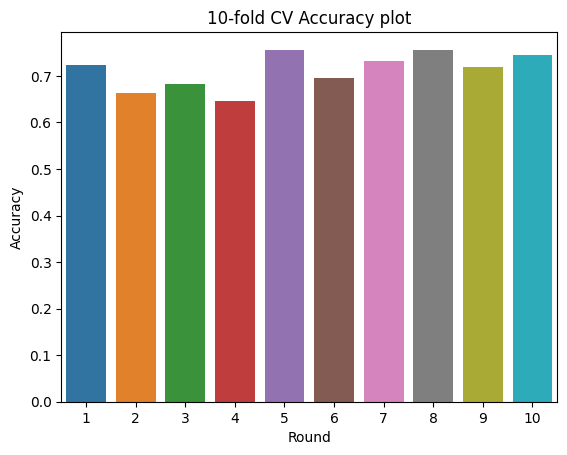

Score avg on 10-fold CV: 0.7117249485747871


Final Model

Accuracy:  0.8 

Classification Report

              precision    recall  f1-score   support

       Coche       0.80      0.83      0.81        86
          TP       0.80      0.77      0.79        79

    accuracy                           0.80       165
   macro avg       0.80      0.80      0.80       165
weighted avg       0.80      0.80      0.80       165
 

Confusion Matrix



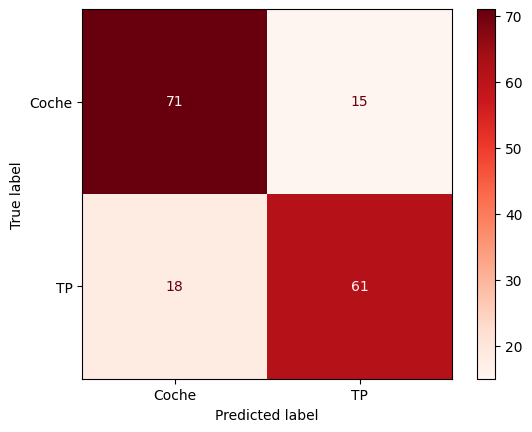

In [33]:
# Train-Test Split

X = np.array(trips.drop(columns="Modo"))
y = np.array( trips["Modo"] )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Model Training/Evaluation Framework

models = {}
def train_evaluate(model,X=X,y=y,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,k=10,cross_validation=True):
    model_name = type(model).__name__

    # El objetivo del cross-validation es evaluar el rendimiento del algoritmo de ML (rf in this case)
    # Pero no se usa luego para nada mas, el modelo que se entrena es otro, con otros datos

    if cross_validation==True:
        print(model_name,"\n")
        print(f"{k}-FOLD CV\n")
        # k fold cross validation

        cv_scores = cross_val_score(model, X, y, cv=k,n_jobs=-1)

        # Scores on k-fold CV
        # Imprimir el score de cada ronda
        for i,score in zip(range(1,k+1),cv_scores):
            print(f"Round {i} score: {score}")
        print("")

        ax = sns.barplot(x = np.arange(1,11), y = np.array(cv_scores))
        ax.set(xlabel='Round', ylabel='Accuracy',title=f"{k}-fold CV Accuracy plot")
        plt.show()

        # scores avg on k-fold CV
        print(f"Score avg on {k}-fold CV: {cv_scores.mean()}\n")


    # Final Model
    print("\nFinal Model\n")
    # Model Training
    model = model.fit(X_train,y_train)
    print("Accuracy: ",model.score(X_test,y_test),"\n")
    # Prediction and Report
    y_pred = model.predict(X_test)
    print("Classification Report\n")
    print(metrics.classification_report(y_test, y_pred),"\n")

    print("Confusion Matrix\n")
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Reds")
    models[model_name] = model


    #pickle
    with open(os.path.join("models",f'{model_name}.pkl'), 'wb') as file:
        pkl.dump(model, file)

# Model Definiton and Evaluation

rf = RandomForestClassifier(n_estimators=20,random_state=random_state)
# rf = DecisionTreeClassifier(max_depth=5)
# rf = AdaBoostClassifier()
# rf = KNeighborsClassifier()
# rf = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),learning_rate=0.5, n_estimators=20,random_state=random_state)
train_evaluate(rf)

Elapsed time to compute the importances: 0.003 seconds


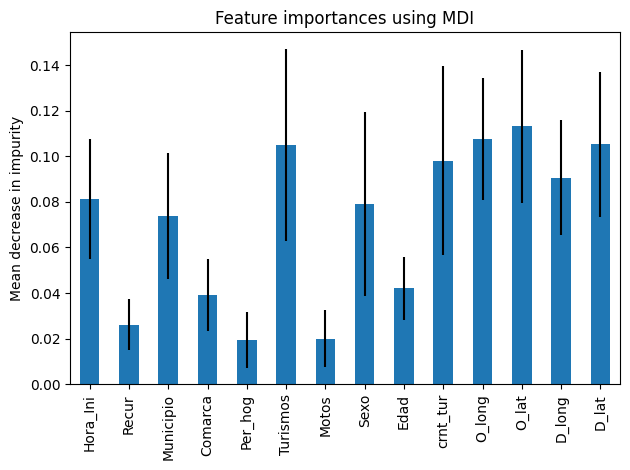

In [32]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
forest_importances = pd.Series(importances, index=trips.drop(columns='Modo').columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()